In [1]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects
from tensorflow.keras.datasets import mnist as mnist

## for Model definition/training
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate,  Dropout, Conv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

In [3]:
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns


In [4]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
def mnist_generator():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    train_dict = defaultdict(lambda: [])
    for i in range(len(x_train)):
        train_dict[y_train[i]].append(x_train[i])
    for keys in train_dict:
        train_dict[keys] = np.array(train_dict[keys])
    labels = np.arange(9)
    
    while(True):
        
        sample = np.random.choice(labels, 6, replace=False)
        p_choices =np.random.choice(len(train_dict[sample[0]])-1, 10, replace=False)
        n_choices =[np.random.choice(len(train_dict[sample[i]])-1, 1, replace=False)[0] for i in range(1, 6)]
        
        positive_image = train_dict[sample[0]][p_choices].reshape(10, 28, 28, 1)
        negative_image = np.array([train_dict[sample[i]][n_choices[i-1]] for i in range(1, 6)]).reshape(5, 28, 28, 1)
        
        
        y = [sample[0] for i in range(10)]
        for i in range(1, 6):
            y.append(sample[i])
#         print(np.vstack((positive_image / 255., negative_image / 255.)).shape, y.shape)
        yield np.vstack((positive_image / 255., negative_image / 255.)), np.array(y)

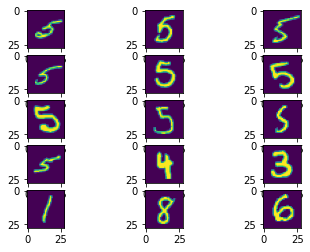

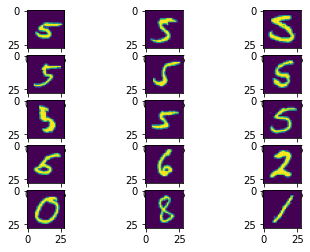

In [7]:

# Visualize the generator mini batch, expect to see 10 sample which same class and 5 sample from different class
k = 0
x_ = None
columns = 3
rows = 5
for train, labels in mnist_generator():
    k += 1
    if k >= 3:
        break
    # Show random images
    x_ = train

    fig=plt.figure()

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(x_[i-1].reshape(28, 28))
    plt.show()

In [8]:
# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [9]:
x_train_flat = x_train.reshape(-1,784)
x_test_flat = x_test.reshape(-1,784)

In [10]:
x_train_flat.shape

(60000, 784)

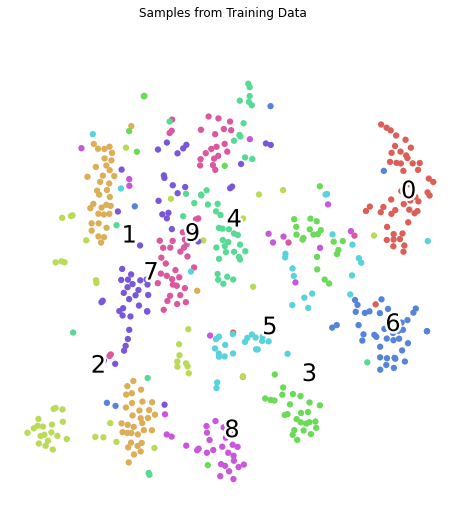

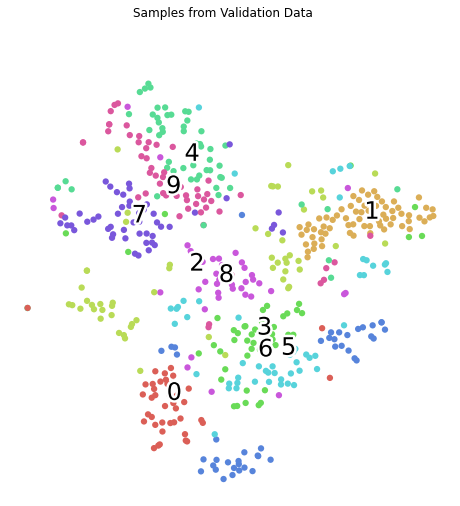

In [11]:

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, y_train[:512], "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])
scatter(eval_tsne_embeds, y_test[:512], "Samples from Validation Data")

In [10]:
# Classifier_input = Input((784,))
# Classifier_output = Dense(10, activation='softmax')(Classifier_input)
# Classifier_model = Model(Classifier_input, Classifier_output)

In [12]:
from sklearn.preprocessing import LabelBinarizer
from itertools import permutations

In [13]:
le = LabelBinarizer()

In [14]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [15]:
X_train, X_test = generate_triplet(x_train_flat,y_train, ap_pairs=150, an_pairs=150,testsize=0.2)

In [16]:
import tensorflow.keras.backend as K
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [31]:
def triplets_loss(y_true, y_pred):
    
#     embeddings = K.cast(embeddings, 'float32')
#     with sess.as_default():
#         print(embeddings.eval())
    
    embeddings = y_pred
    anchor_positive = embeddings[:10]
    negative = embeddings[10:]
#     print(anchor_positive)

    # Compute pairwise distance between all of anchor-positive
    dot_product = K.dot(anchor_positive, K.transpose(anchor_positive))
    square = K.square(anchor_positive)
    a_p_distance = K.reshape(K.sum(square, axis=1), (-1,1)) - 2.*dot_product  + K.sum(K.transpose(square), axis=0) + 1e-6
    a_p_distance = K.maximum(a_p_distance, 0.0) ## Numerical stability
#     with K.get_session().as_default():
#         print(a_p_distance.eval())
#     print("Pairwise shape: ", a_p_distance)
#     print("Negative shape: ", negative)

    # Compute distance between anchor and negative
    dot_product_2 = K.dot(anchor_positive, K.transpose(negative))
    negative_square = K.square(negative)
    a_n_distance = K.reshape(K.sum(square, axis=1), (-1,1)) - 2.*dot_product_2  + K.sum(K.transpose(negative_square), axis=0)  + 1e-6
    a_n_distance = K.maximum(a_n_distance, 0.0) ## Numerical stability
    
    hard_negative = K.reshape(K.min(a_n_distance, axis=1), (-1, 1))
    
    distance = (a_p_distance - hard_negative + 0.2)
    loss = K.mean(K.maximum(distance, 0.0))/(2.)

#     with K.get_session().as_default():
#             print(loss.eval())
            
    return loss

In [32]:
def create_base_network(in_dims):
    """
    Base network to be shared.
    """
    model = Sequential()
    model.add(Conv2D(32,(3,3),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    model.add(MaxPool2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(32,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPool2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(4,name='embeddings'))
    # model.add(Dense(600))
    
    return model

In [33]:
# declare a simple CNN network
# def baseline_model():
#     # create model
#     model = Sequential()
    
#     model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(pool_size=(2, 2)))
    
#     model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#     model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(pool_size=(2, 2)))
    
#     model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dense(32))
#     # Compile model
#     optim = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
#     model.compile(loss=triplets_loss, optimizer=optim)
#     model.summary()
#     return model

In [34]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
anchor_input = Input((28,28,1, ), name='anchor_input')
positive_input = Input((28,28,1, ), name='positive_input')
negative_input = Input((28,28,1, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([28,28,1,])


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

In [35]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4)            32228       anchor_input[0][0]               
                                                                 positive_input[0][0]  

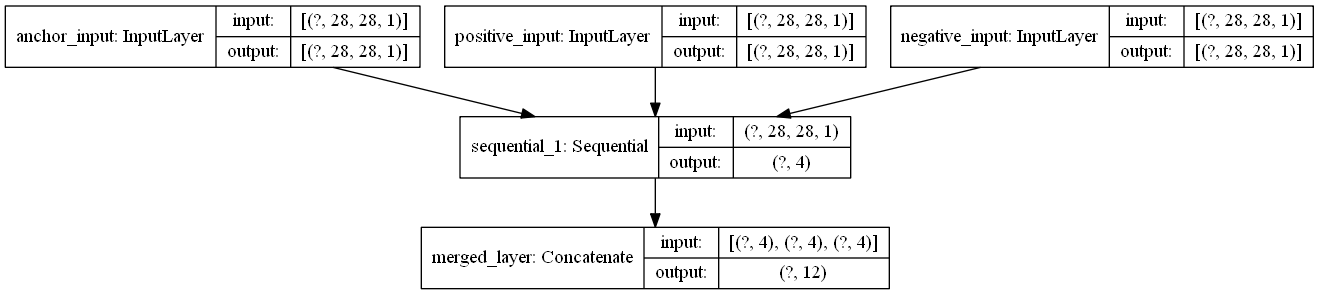

In [29]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Anchor = X_train[:,0,:].reshape(-1,28,28,1)
Positive = X_train[:,1,:].reshape(-1,28,28,1)
Negative = X_train[:,2,:].reshape(-1,28,28,1)
Anchor_test = X_test[:,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:,2,:].reshape(-1,28,28,1)

Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=512, epochs=10)

In [30]:
model.save("triplet_model_MNIST.hdf5")

In [23]:

trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)

In [24]:
trained_model.load_weights('triplet_model_MNIST.hdf5')


In [25]:
tsne = TSNE()
X_train_trm = trained_model.predict(x_train[:512].reshape(-1,28,28,1))
X_test_trm = trained_model.predict(x_test[:512].reshape(-1,28,28,1))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)

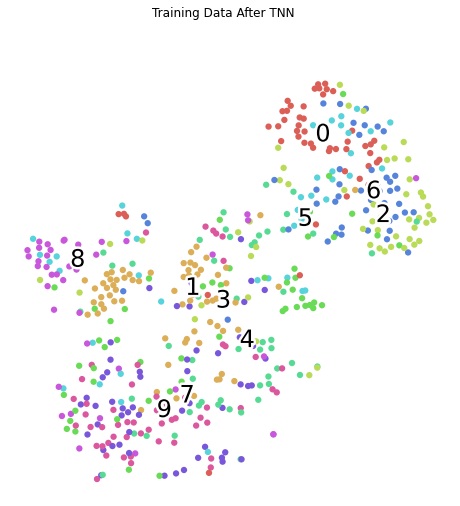

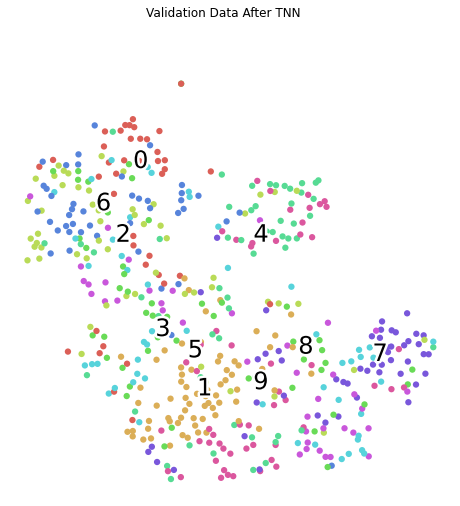

In [26]:
scatter(train_tsne_embeds, y_train[:512], "Training Data After TNN")
scatter(eval_tsne_embeds, y_test[:512], "Validation Data After TNN")
